In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from skimage.transform import rescale
from skimage import img_as_uint,img_as_ubyte
import tifffile as tiff

import tensorflow as tf
import skimage.io as io
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,ConvLSTM2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

In [3]:
seq = Sequential()
seq.add(ConvLSTM2D(filters=10, kernel_size=(3, 3),
                   input_shape=(None,512,512, 1),
                   padding='same',data_format='channels_last' , return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=10, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=10, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=10, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')

In [4]:
def trainGenerator(batch_size, train_path, img_folder, mask_folder, aug_dict, color_mode = 'grayscale', 
                   mask_color_mode = 'grayscale', target_size = (512,512), seed = 1):
    
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(train_path, classes = [img_folder], class_mode = None,
                                                        color_mode = color_mode, target_size = target_size, 
                                                        batch_size = batch_size, seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(train_path, classes = [mask_folder], class_mode = None,
                                                      color_mode = mask_color_mode, target_size = target_size,
                                                      batch_size = batch_size, seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask)
        yield (np.expand_dims(np.expand_dims(img[0],axis=0),axis=0),np.expand_dims(np.expand_dims(mask[0],axis=0),axis=0))
        
        
def adjustData(img,mask):
    j = 0
    if(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)


def testGenerator(test_path,num_image,target_size = (512,512)):#,as_gray = True):
    for i in range(0, num_image):
        img = io.imread(os.path.join(test_path,"%d.tif"%i))#,as_gray = as_gray)
        #img = img / 255
        img = np.reshape(img,img.shape+(1,))
        img = np.reshape(img,(1,)+img.shape)
        yield (np.expand_dims(np.expand_dims(img[0],axis=0),axis=0))
        
    

In [5]:
data_gen_args = dict(rotation_range=0.2, width_shift_range=0.05, height_shift_range=0.05, shear_range=0.05,
                     zoom_range=0.05, horizontal_flip=True, fill_mode='nearest')

#tr_img = trainGenerator(1,"train/image_processed/","train/label_processed/")
myGene = trainGenerator(1,'train','image_processed','label_processed',data_gen_args)
#model = unet_model(512,512,1)
seq.fit_generator(myGene,steps_per_epoch=130,epochs=1,callbacks=None,verbose=1)
#model.save('unet_model.h5')

Epoch 1/1
Found 65 images belonging to 1 classes.
Found 65 images belonging to 1 classes.
130/130 [==============================] - ETA: 21:54 - loss: 0.74 - ETA: 11:29 - loss: 0.74 - ETA: 8:01 - loss: 0.7327 - ETA: 6:17 - loss: 0.724 - ETA: 5:14 - loss: 0.719 - ETA: 4:31 - loss: 0.715 - ETA: 4:01 - loss: 0.712 - ETA: 3:38 - loss: 0.708 - ETA: 3:20 - loss: 0.705 - ETA: 3:06 - loss: 0.702 - ETA: 2:54 - loss: 0.699 - ETA: 2:44 - loss: 0.696 - ETA: 2:35 - loss: 0.694 - ETA: 2:28 - loss: 0.692 - ETA: 2:21 - loss: 0.689 - ETA: 2:15 - loss: 0.687 - ETA: 2:10 - loss: 0.685 - ETA: 2:06 - loss: 0.683 - ETA: 2:01 - loss: 0.681 - ETA: 1:57 - loss: 0.679 - ETA: 1:54 - loss: 0.677 - ETA: 1:51 - loss: 0.675 - ETA: 1:48 - loss: 0.673 - ETA: 1:45 - loss: 0.671 - ETA: 1:42 - loss: 0.669 - ETA: 1:40 - loss: 0.667 - ETA: 1:37 - loss: 0.665 - ETA: 1:35 - loss: 0.663 - ETA: 1:33 - loss: 0.661 - ETA: 1:31 - loss: 0.659 - ETA: 1:29 - loss: 0.656 - ETA: 1:27 - loss: 0.654 - ETA: 1:25 - loss: 0.652 - ETA: 1:2

In [6]:
testGene = testGenerator("test/image_processed/", 3)
results = seq.predict_generator(testGene,3,verbose=1)

3/3 [==============================] - ETA:  - ETA:  - 1s 300ms/step


In [7]:
results.shape

(3, 1, 512, 512, 1)

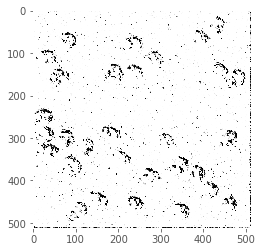

In [8]:
plt.imshow(results[1][0].reshape(512,512),cmap='Greys')

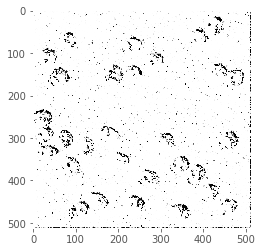

In [9]:
plt.imshow(results[0][0].reshape(512,512),cmap='Greys')

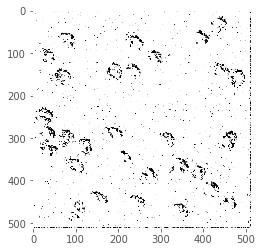

In [10]:
plt.imshow(results[2][0].reshape(512,512),cmap='Greys')